libraries needed:

In [ ]:
import math
import cv2
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt
import dataclasses
from typing import List, Optional, Tuple
from mediapipe.framework.formats import landmark_pb2

# utility/helper functions:

In [ ]:
def findAngle(p1:np.array, p2:np.array, p3:np.array):
    v1 = p1-p2
    v2 = p3-p2
    v1_mag,v2_mag = np.linalg.norm(v1), np.linalg.norm(v2)
    
    if(v1_mag == 0 or v2_mag == 0): 
        print("trying to divide by zero prevented")
        return 0

    v1 = v1 / v1_mag; v2 = v2 / v2_mag
    return math.acos(v1[0] * v2[0] + v1[1] * v2[1] + v1[2] * v2[2])  # v1.x * v2.x + v1.y * v2.y + v1.z * v2.z

In [ ]:
# # # # # # # # # # GRAPHICS UTILITY

from mpl_toolkits.mplot3d.art3d import Line3DCollection

# Function to generate gradient colors interpolating between two colors
def get_gradient_color(colors, n):
    start_color, end_color = colors
    r = np.linspace(start_color[0], end_color[0], n)
    g = np.linspace(start_color[1], end_color[1], n)
    b = np.linspace(start_color[2], end_color[2], n)
    return list(zip(r, g, b))

def draw_gradient_line_3d(
    ax_thing, start, end, left_intensity, right_intensity, num_points=100
):
    # Generate points along the line in 3D space
    x = np.linspace(start[0], end[0], num_points)
    y = np.linspace(start[1], end[1], num_points)
    z = np.linspace(start[2], end[2], num_points)
    
    # red to green to red interpolation based on red intensity on both ends 
    colors = get_gradient_color(
        [(left_intensity, 1-left_intensity, 0), (0, 1, 0)],
        num_points // 2,
    ) + get_gradient_color(
        [(0,1,0), (right_intensity, 1-right_intensity, 0)], num_points // 2
    )
    points = np.column_stack([x, y, z])

    line = Line3DCollection(list(zip(points[:-1], points[1:])), colors=colors, linewidths=3,zorder= 2)

    # Add the line to the 3D plot
    ax_thing.add_collection3d(line)

def _normalize_color(color):
    return tuple(v / 255.0 for v in color)
@dataclasses.dataclass
class DrawingSpec:
    # Color for drawing the annotation. Default to the white color.
    color: Tuple[int, int, int] = (224, 224, 224)
    # Thickness for drawing the annotation. Default to 2 pixels.
    thickness: int = 2
    # Circle radius. Default to 2 pixels.
    circle_radius: int = 2


_PRESENCE_THRESHOLD = 0.5
_VISIBILITY_THRESHOLD = 0.5

# Classifier Class

In [ ]:
class Classifier:
    def __init__(self, img_path, fig_title):
        self.img = cv2.imread(img_path)
       
        plt.figure(figsize=[5, 5])
        plt.title(fig_title)
        plt.imshow(self.img[:, :, ::-1])
        plt.show()

        self.mp_pose = mp.solutions.pose
        self.pose = self.mp_pose.Pose(
            static_image_mode=True, min_detection_confidence=0.3, model_complexity=2
        )
        self.mp_drawing = mp.solutions.drawing_utils

    def detect_keypoints(self, verbose=True):
        self.results = self.pose.process(
            cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        )  # converting image to rgb format
        self.landmarks = []
        if self.results.pose_landmarks:
            for i in range(33):
                norm_landmark = self.results.pose_landmarks.landmark[
                    self.mp_pose.PoseLandmark(i).value
                ]
                if verbose:
                    print(f"{self.mp_pose.PoseLandmark(i).name}:\n{norm_landmark}")
                self.landmarks.append(
                    np.array([norm_landmark.x, norm_landmark.y, norm_landmark.z])
                )

    def plot_keypoints(self, fig_title=""):
        img_copy = self.img.copy()
        if self.results.pose_landmarks:
            self.mp_drawing.draw_landmarks(
                image=img_copy,
                landmark_list=self.results.pose_landmarks,
                connections=self.mp_pose.POSE_CONNECTIONS
            )
            fig = plt.figure(figsize=[5, 5])
            plt.title(fig_title)
            plt.imshow(img_copy[:, :, ::-1])
            plt.show()

            # for 3d

            self.mp_drawing.plot_landmarks(
                self.results.pose_world_landmarks, self.mp_pose.POSE_CONNECTIONS
            )
            plt.show()

    def calculate_arms_and_angles(
        self,
        landmarks,
        landmark_list: landmark_pb2.NormalizedLandmarkList,
        connections: Optional[List[Tuple[int, int]]] = None,
    ):
        arms_and_angles = [
            None for _ in range(len(landmarks))
        ]  # {i:set() for i in range(len(landmarks))}
        connected_points = [set() for _ in range(len(self.landmarks))]
        self.plotted_landmarks = {}

        # # # LOOPING THROUGH EACH LANDMARK
        for idx, landmark in enumerate(landmark_list.landmark):
            if (
                landmark.HasField("visibility")
                and landmark.visibility < _VISIBILITY_THRESHOLD
            ) or (
                landmark.HasField("presence")
                and landmark.presence < _PRESENCE_THRESHOLD
            ):
                continue

            self.plotted_landmarks[idx] = (-landmark.z, landmark.x, -landmark.y)

        if connections:
            num_landmarks = len(landmark_list.landmark)

            for connection in connections:
                start_idx = connection[0]
                end_idx = connection[1]

                if not (
                    0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks
                ):
                    raise ValueError(
                        f"Landmark index is out of range. Invalid connection "
                        f"from landmark #{start_idx} to landmark #{end_idx}."
                    )
                if (
                    start_idx in self.plotted_landmarks
                    and end_idx in self.plotted_landmarks
                ):
                    try:
                        # add each other the other's 'connected points' set
                        # print(start_idx,end_idx,f"{'same!' if start_idx == end_idx else ''}")
                        connected_points[start_idx].add(end_idx)
                        connected_points[end_idx].add(start_idx)
                    except IndexError as e:
                        print(e)
                        print(
                            "start_idx:",
                            start_idx,
                            "end_idx:",
                            end_idx,
                            f"len(connected_points):{len(connected_points)}",
                        )

        # now we got a set of connected points for each landmark, lets figure out the angles for every set of 3 connected points ( v ^ L \_ )

        print(
            "looping through every point again to find the angle between every group of 3 linearly connected points"
        )
        # print(landmarks)
        for vertex in range(len(connected_points)):
            points = list(connected_points[vertex])

            num_connections = len(points)
            if num_connections > 1:
                angles = []
                arms = []
                for i in range(num_connections - 1):
                    for j in range(i + 1, num_connections):
                        try:
                            # print(landmarks[points[i]],landmarks[vertex],landmarks[points[j]])

                            angle = findAngle(
                                landmarks[points[i]],
                                landmarks[vertex],
                                landmarks[points[j]],
                            )
                            angles.append(angle)
                            arms.append(frozenset({points[i], points[j]}))
                        except IndexError as e:
                            print(
                                f"i:{i},j:{j},len(points):{len(points)},len(landmarks):{len(landmarks)},points[i]:{points[i]},points[j]:{points[j]}"
                            )
                # have to convert arms set to a frozenset because keys have to be of immutable type
                arms_and_angles[vertex] = dict(zip(arms, angles))

        return arms_and_angles

    def plot_3d_graphics(
        self,
        landmark_list: landmark_pb2.NormalizedLandmarkList,
        connections: Optional[List[Tuple[int, int]]] = None,
        elevation: int = 10,
        azimuth: int = 10,
        fig_size=(10, 10),
        font_size=5,
        landmark_drawing_spec: DrawingSpec = DrawingSpec(
            color=(255, 255, 0), thickness=1
        ),
        ideal_arms_and_angles = None,
        fig_title=""
    ):
        
        plt.figure(figsize=fig_size)
        ax = plt.axes(projection="3d")
        ax.set_title(fig_title)
        ax.view_init(elev=elevation, azim=azimuth)

        

        if(not ideal_arms_and_angles):
            print("ideal angles not found")
            return

        keypoint_colours = {key:(0,1,0) for key in self.plotted_landmarks.keys()}

        # GRADIENT ERROR CONNECTORS
        if connections:
            num_landmarks = len(landmark_list.landmark)
            # Draws the connections if the start and end landmarks are both visible.

            for connection in connections:
                start_idx = connection[0]
                end_idx = connection[1]

                if not (
                    0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks
                ):
                    raise ValueError(
                        f"Landmark index is out of range. Invalid connection "
                        f"from landmark #{start_idx} to landmark #{end_idx}."
                    )
                if (
                    start_idx in self.plotted_landmarks
                    and end_idx in self.plotted_landmarks
                ):
                    landmark_pair = [
                        self.plotted_landmarks[start_idx],
                        self.plotted_landmarks[end_idx],
                    ]


                    left,right = 0,0
                    # arms_and_angles[vertex] = dict(zip(arms, angles))
                    # ideal_arms_and_angles[start_idx]
                    if(self.arms_and_angles[start_idx]):
                        for arms,angle in self.arms_and_angles[start_idx].items():
                            if(end_idx in arms):
                                if(arms in ideal_arms_and_angles[start_idx]):
                                    diff = abs(ideal_arms_and_angles[start_idx][arms]-angle)
                                    left = max(left,diff/(math.pi))

                    if(self.arms_and_angles[end_idx]):
                        for arms,angle in self.arms_and_angles[end_idx].items():
                            if(end_idx in arms):
                                if(arms in ideal_arms_and_angles[end_idx]):
                                    diff = abs(ideal_arms_and_angles[end_idx][arms]-angle)
                                    right = max(right,diff/(math.pi))
                    left *= 10;
                    right*=10; # scaling up to pronounce errors

                    if(left):
                        keypoint_colours[start_idx]=(left,1-left,0)
                    if(right):
                        keypoint_colours[end_idx]=(right,1-right,0)
                    # print(right,left)
                            

                    draw_gradient_line_3d(
                        ax_thing=ax,
                        start=[_ for _ in landmark_pair[0]],
                        end=[_ for _ in landmark_pair[1]],
                        left_intensity=left,
                        right_intensity=right,
                        num_points=100,
                    )
        
        # KEYPOINTS
        for key,plotted_landmark in self.plotted_landmarks.items():
            ax.scatter3D(
                xs=plotted_landmark[0],
                ys=plotted_landmark[1],
                zs=plotted_landmark[2],
                color=_normalize_color(landmark_drawing_spec.color[::-1]),
                linewidth=landmark_drawing_spec.thickness,
                zorder=1,
            )

        # # print the keypoint names and number of angles associated with it
        # for idx, pos in self.plotted_landmarks.items():
        #     label = self.mp_pose.PoseLandmark(idx).name
        #     ax.text(
        #         pos[0],
        #         pos[1],
        #         pos[2],
        #         s=f"{idx}." + label # + ":" + str((self.arms_and_angles[idx]))
        #         if self.arms_and_angles[idx]
        #         else label,
        #         fontsize=font_size,
        #         color="blue",
        #         zorder=5,
        #         zdir="y",
        #     )

        plt.show()

    def calculate_angles(self):
        self.arms_and_angles = self.calculate_arms_and_angles(
            self.landmarks, self.results.pose_world_landmarks, self.mp_pose.POSE_CONNECTIONS
        )

    def draw3dErrorDetectedSkeleton(self,idealPose:Classifier, title):
        if self.results.pose_landmarks:
            self.plot_3d_graphics(
                self.results.pose_world_landmarks, self.mp_pose.POSE_CONNECTIONS,ideal_arms_and_angles=idealPose.arms_and_angles,fig_title=title)

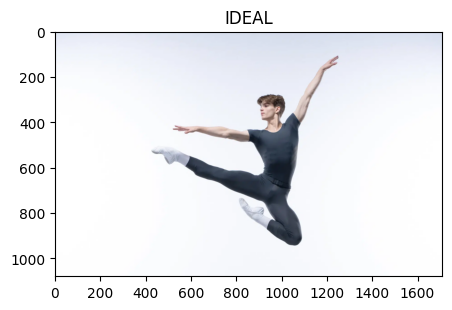

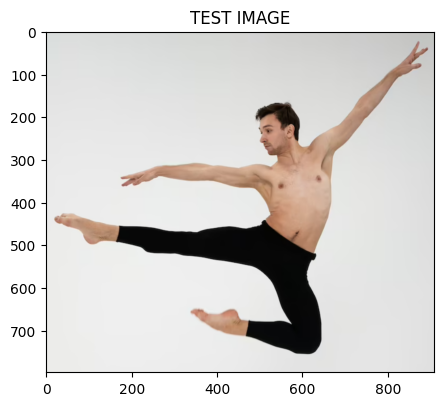

In [ ]:
ideal = Classifier('media/ballerina1.png',"IDEAL")
b1 = Classifier('media/ballerina2.png', "TEST IMAGE")

In [ ]:
print("Landmarks are extracted:")
ideal.detect_keypoints(verbose=False)
ideal.plot_keypoints()
b1.detect_keypoints(verbose=False)
b1.plot_keypoints()

: 

: 

looping through every point again to find the angle between every group of 3 linearly connected points
looping through every point again to find the angle between every group of 3 linearly connected points


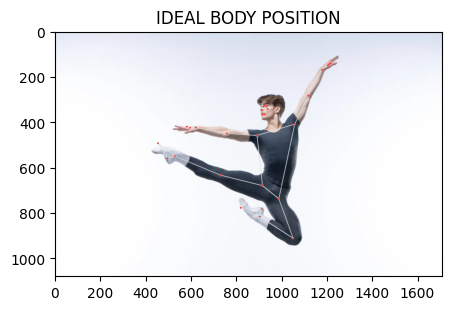

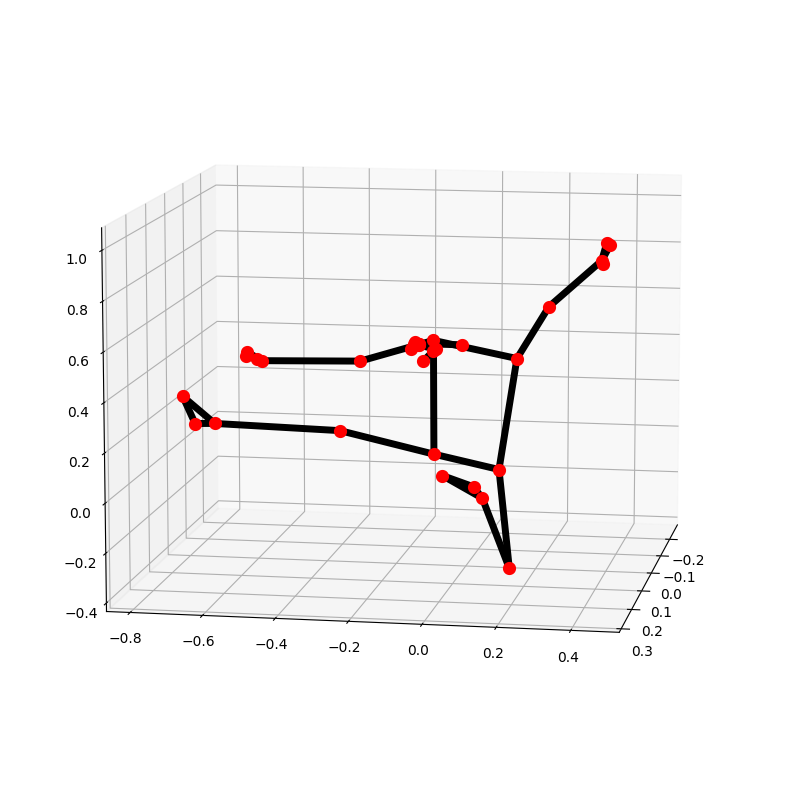

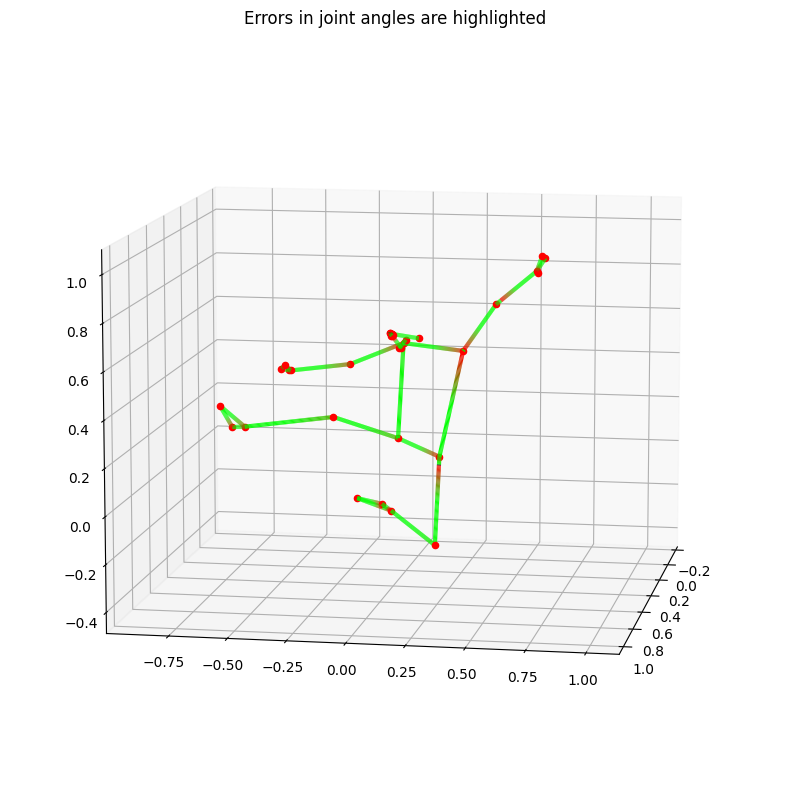

In [ ]:
b1.calculate_angles()
ideal.calculate_angles()

ideal.plot_keypoints(fig_title="IDEAL BODY POSITION")
b1.draw3dErrorDetectedSkeleton(ideal,"Errors in joint angles are highlighted")